# Import libraries and data

In [18]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, f1_score, \
    confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC

from utils import keep_first_uniprot

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature brain data set

In [165]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain.csv")
df_features

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00022,PS01186,Glycosylation sites,Glycosylation,GlycoMine_N,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,CSF
0,Q8TDC3,MSSGAKEGGGGSPAYHLPHPHPHPPQHAQYVGPYRLEKTLGKGQTG...,778,85085.7493,0.051414,0.012853,0.043702,0.065553,0.029563,0.092545,...,0,0,0.0,0.0,1,1,0,0,0,1
1,P48065,MDGKVAVQECGPPAVSWVPEEGEKLDQEDEDQVKDRGQWTNKMEFV...,614,69367.5176,0.052117,0.037459,0.030945,0.043974,0.083062,0.081433,...,0,0,2.0,2.0,1,0,0,0,0,-1
2,Q9Y250,MGSVSSLISGHSFHSKHCRASQYKLRKSSHLKKLNRYSDGLLRFGF...,596,66612.1565,0.060403,0.011745,0.041946,0.104027,0.023490,0.072148,...,0,0,1.0,1.0,1,1,0,0,0,-1
3,P0DMW5,MAASAALSAAAAAAALSGLAVRLSRSAAARGSYGAFCKGLTRTLLT...,78,8388.8176,0.230769,0.012821,0.012821,0.012821,0.064103,0.051282,...,0,0,0.0,0.0,0,0,0,0,0,-1
4,P21579,MVSESHHEALAAPPVTTVATVLPSNATEPASPGEGKEDAFSKLKEK...,422,47572.5391,0.063981,0.014218,0.061611,0.082938,0.045024,0.059242,...,0,0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,Q8IZU8,MALMFTGHLLFLALLMFAFSTFEESVSNYSEWAVFTDDIDQFKTQK...,1212,139235.8716,0.067657,0.009076,0.045380,0.048680,0.063531,0.055281,...,0,0,0.0,0.0,0,0,0,0,1,-1
2538,Q4JDL3,MSSPRDFRAEPVNDYEGNDSEAEDLNFRETLPSSSQENTPRSKVFE...,420,48422.3273,0.047619,0.019048,0.057143,0.083333,0.052381,0.045238,...,0,0,0.0,0.0,0,0,0,0,0,-1
2539,Q8N4V2,MEEDLFQLRQLPVVKFRRTGESARSEDDTASGEHEVQIEGVHVGLE...,548,60768.4670,0.085766,0.023723,0.031022,0.062044,0.056569,0.082117,...,0,0,2.0,2.0,0,0,0,0,0,-1
2540,P48426,MATPGNLGSSVLASKTKTKKKHFVAQKVKLFRASDPLLSVLMWGVN...,406,46224.0440,0.056650,0.009852,0.068966,0.073892,0.046798,0.051724,...,0,0,0.0,0.0,0,1,0,0,0,-1


## CSF data set

In [4]:
csf = pd.read_csv(data_path + "CSF/all_csf_1000plus.csv")

## Brain proteome (HPA)

In [5]:
brain_elevated = pd.read_csv(data_path + "Brain/HPA_all_brain_elevated_version21.tsv", sep="\t")
print("Number of brain elevated proteins according to the HPA: %i" % len(brain_elevated))
brain_elevated.dropna(subset=["Uniprot"], inplace=True)
brain_elevated.drop_duplicates(subset=["Uniprot"], inplace=True)
print("Number of brain elevated proteins with a Uniprot ID: %i" % len(brain_elevated))

Number of brain elevated proteins according to the HPA: 2709
Number of brain elevated proteins with a Uniprot ID: 2546


In [6]:
brain_elevated["Uniprot"] = brain_elevated["Uniprot"].apply(keep_first_uniprot)

In [7]:
# create data subsets based on tissue specificity
# tissue enhanced + group enriched + tissue enriched
brain_tissue_enhanced = set(brain_elevated["Uniprot"])
# group enriched + tissue enriched
brain_group_enriched = set(brain_elevated[brain_elevated["RNA tissue specificity"].isin(["Group enriched", 
    "Tissue enriched"])]["Uniprot"])
# tissue enriched
brain_tissue_enriched = set(brain_elevated[brain_elevated["RNA tissue specificity"] == "Tissue enriched"]["Uniprot"])

In [8]:
# create data subsets based on tissue distribution
# detected in all + many + some + single
brain_all = set(brain_elevated["Uniprot"])
# detected in many + some + single
brain_many = set(brain_elevated[brain_elevated["RNA tissue distribution"].isin(["Detected in many", "Detected in some",
    "Detected in single"])]["Uniprot"])
# detected in some + single
brain_some = set(brain_elevated[brain_elevated["RNA tissue distribution"].isin(["Detected in some", 
    "Detected in single"])]["Uniprot"])
# detected in single
brain_single = set(brain_elevated[brain_elevated["RNA tissue distribution"] == "Detected in single"]["Uniprot"])

print(len(brain_all), len(brain_many), len(brain_some), len(brain_single))

2546 2214 1163 165


# Machine Learning

In [9]:
# define variables and target
X = (df_features.drop(["Uniprot", "Sequence", "CSF"], axis=1))
y = (df_features["CSF"])

In [10]:
# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 
        'Volume_medium', 'Volume_large', 'Polarity_low', 'Polarity_medium', 'Polarity_large', 'Polarizability_low', 
        'Polarizability_medium', 'Polarizability_large', 'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried',
        'Exposed', 'Intermediate', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 
        'First60ExpAA', 'PredHel']

## Model selection

Linear SVC
- penalty {‘l1’, ‘l2’}, default=’l2’: Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.

- dual bool, default=True: Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.

- C float, default=1.0: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

- max_iterint, default=1000: The maximum number of iterations to be run.

Logistic Regression
- solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’: Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:
    - For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
    - For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
    - ‘liblinear’ is limited to one-versus-rest schemes.

Warning The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:
- ‘newton-cg’ - [‘l2’, ‘none’]
- ‘lbfgs’ - [‘l2’, ‘none’]
- ‘liblinear’ - [‘l1’, ‘l2’]
- ‘sag’ - [‘l2’, ‘none’]
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

In [111]:
def scale_data(X_train, X_test, scaler=StandardScaler(), scaled=cont):
    """
    Default is Standard Scaler (standardization) on all variables.
    """
    
    if scaled == "all":
        # scale all variables
        X_train_scal = scaler.fit_transform(X_train)
        X_test_scal = scaler.transform(X_test)

    else:
        # scale continuous variables
        X_train_scal = X_train.copy()
        X_train_scal[scaled] = scaler.fit_transform(X_train_scal[scaled])
        X_test_scal = X_test.copy()
        X_test_scal[scaled] = scaler.transform(X_test_scal[scaled])
        
    return X_train_scal, X_test_scal


def preprocess(X, y, random_state=0):
    
    # preprocessing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)  
    X_train_scal, X_test_scal = scale_data(X_train, X_test, scaler=StandardScaler(), scaled=cont)
    X_train_bal, y_train_bal = RandomUnderSampler(random_state=0).fit_resample(X_train_scal, y_train)
    
    return X_train_bal, X_test_scal, y_train_bal, y_test

In [112]:
def model_selection(model, X, y, n=5, scaler=StandardScaler(), scaled="all"):
    """
    """
    # create empty list to save performance measurements
    bac = []
    f1 = []
    auc = []

    for i in range(n):
        
        X_train_bal, X_test_scal, y_train_bal, y_test = preprocess(X, y, random_state=i)
        
        # fit classifier to training data
        model.fit(X_train_bal, y_train_bal)
        # predict on test set
        y_pred = model.predict(X_test_scal) 
        
        # measure performance of model
        bac.append(balanced_accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        try:
            auc.append(roc_auc_score(y_test, model.predict_proba(X_test_scal)[:, 1]))
        except:
            auc.append(roc_auc_score(y_test, model.decision_function(X_test_scal)))

        
    print("Balanced accuracy: %.4f" % np.mean(bac))
    print("F1-score: %.4f" % np.mean(f1))
    print("AUC: %.4f" % np.mean(auc))
    
    return bac, f1, auc

In [113]:
# train the model
models = [RandomForestClassifier(n_estimators=100, random_state=0),
         LinearSVC(C=0.1, max_iter=1000, dual=False, random_state=0),
         LogisticRegression(max_iter=1000, dual=False, random_state=0)]

baclist = []
f1list = []
auclist = []

for model in models:
    print(model)
    bac, f1, auc = model_selection(model, X, y, n=10, scaler=StandardScaler(), scaled=cont)
    baclist.append(bac)
    f1list.append(f1)
    auclist.append(auc)
    print("--------------")

RandomForestClassifier(random_state=0)
Balanced accuracy: 0.7507
F1-score: 0.6998
AUC: 0.8253
--------------
LinearSVC(C=0.1, dual=False, random_state=0)
Balanced accuracy: 0.7374
F1-score: 0.6860
AUC: 0.8230
--------------
LogisticRegression(max_iter=1000, random_state=0)
Balanced accuracy: 0.7374
F1-score: 0.6860
AUC: 0.8228
--------------


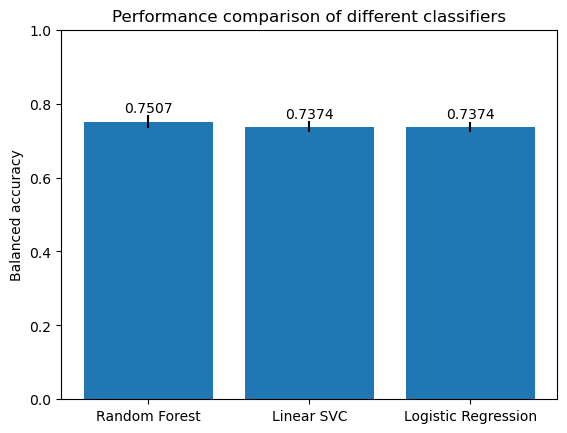

In [107]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in baclist], 
              yerr=[np.std(i) for i in baclist])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="Balanced accuracy", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_BAC.png", bbox_inches="tight")

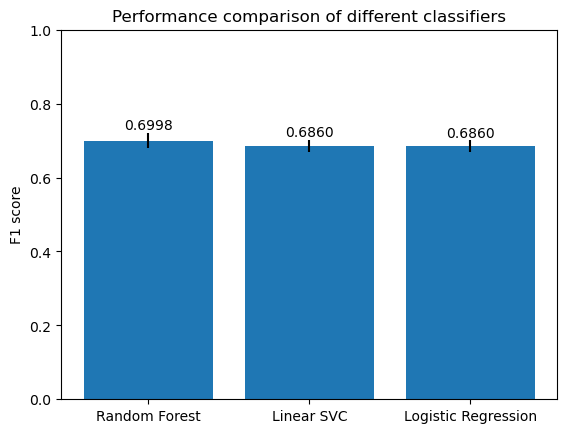

In [108]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in f1list], 
    yerr=[np.std(i) for i in f1list])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="F1 score", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_F1.png", bbox_inches="tight")

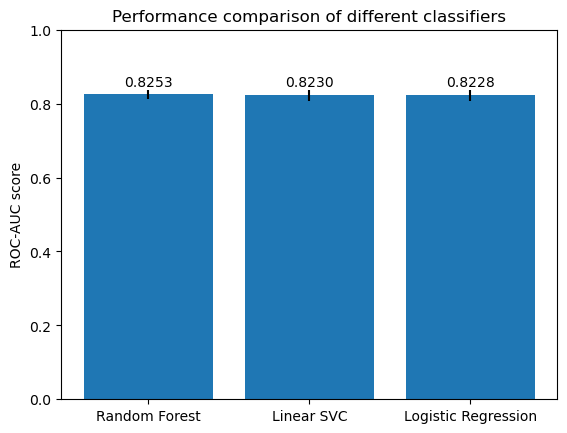

In [109]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in auclist], 
    yerr=[np.std(i) for i in auclist])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="ROC-AUC score", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_AUC.png", bbox_inches="tight")

## Hyperparameter tuning

In [110]:
# preprocessing data 
X_train_bal, X_test_scal, y_train_bal, y_test = preprocess(X, y)

### Linear SVC (L2 regularization)

In [24]:
parameters = {"C":[0.01, 0.1, 0.25, 0.5, 0.75, 1, 10]}
svc_l2 = LinearSVC(penalty="l2", dual=False, random_state=0)
grs_svc_l2 = GridSearchCV(svc_l2, parameters, cv=10)
grs_svc_l2.fit(X_train_bal, y_train_bal)

grid_results_svc_l2 = pd.DataFrame(grs_svc_l2.cv_results_).sort_values("param_C")
grid_results_svc_l2.sort_values("rank_test_score")

# small differences between C-values, optimum between 0.1 and 1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.015900,0.000529,0.001492,0.000498,0.1,{'C': 0.1},0.71875,0.71875,0.767296,0.710692,0.805031,0.761006,0.773585,0.742138,0.748428,0.767296,0.751297,0.028018,1
2,0.019229,0.001796,0.001498,0.000500,0.25,{'C': 0.25},0.71875,0.71875,0.761006,0.698113,0.798742,0.761006,0.773585,0.742138,0.748428,0.767296,0.748781,0.028580,2
3,0.023902,0.003293,0.002053,0.000456,0.5,{'C': 0.5},0.71875,0.71875,0.754717,0.698113,0.798742,0.761006,0.773585,0.742138,0.748428,0.767296,0.748153,0.028373,3
4,0.022215,0.003161,0.001708,0.000463,0.75,{'C': 0.75},0.71250,0.71875,0.754717,0.698113,0.792453,0.767296,0.773585,0.723270,0.748428,0.767296,0.745641,0.029293,4
5,0.024690,0.002861,0.001892,0.000308,1,{'C': 1},0.71250,0.71875,0.754717,0.698113,0.792453,0.767296,0.773585,0.723270,0.748428,0.767296,0.745641,0.029293,4
6,0.032938,0.004440,0.001699,0.000477,10,{'C': 10},0.71250,0.71875,0.761006,0.691824,0.786164,0.767296,0.773585,0.723270,0.748428,0.767296,0.745012,0.029697,6
0,0.011984,0.001342,0.001697,0.000641,0.01,{'C': 0.01},0.71250,0.70625,0.761006,0.723270,0.798742,0.767296,0.767296,0.723270,0.742138,0.735849,0.743762,0.027780,7


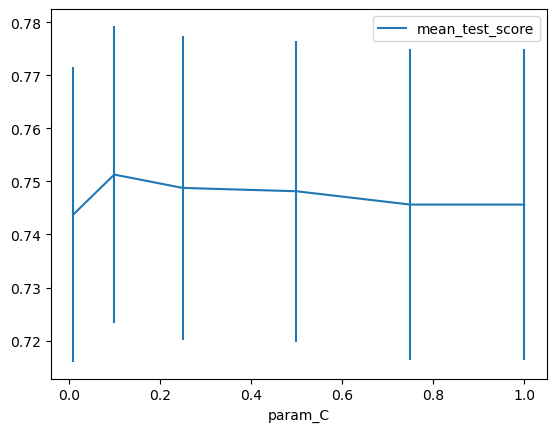

In [23]:
grid_results_svc_l2.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Linear SVC (L1 regularization)

In [27]:
parameters = {"C":[0.01, 0.1, 0.25, 0.5, 0.75, 1]}
svc_l1 = LinearSVC(penalty="l1", max_iter=10000, dual=False, random_state=0)
grs_svc_l1 = GridSearchCV(svc_l1, parameters, cv=10)
grs_svc_l1.fit(X_train_bal, y_train_bal)

grid_results_svc_l1 = pd.DataFrame(grs_svc_l1.cv_results_).sort_values("param_C")
grid_results_svc_l1.sort_values("rank_test_score")

# optimal C value between 0.5 and 1
# for C = 10 convergence warning

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
4,0.370866,0.098892,0.001987,0.000879,0.75,{'C': 0.75},0.71875,0.71250,0.767296,0.710692,0.798742,0.767296,0.773585,0.735849,0.748428,0.773585,0.750672,0.028658,1
3,0.324133,0.183565,0.001908,0.000529,0.5,{'C': 0.5},0.71875,0.71250,0.767296,0.710692,0.798742,0.767296,0.773585,0.735849,0.742138,0.773585,0.750043,0.028769,2
5,0.425924,0.155320,0.001585,0.000648,1,{'C': 1},0.71875,0.71875,0.767296,0.710692,0.792453,0.761006,0.773585,0.729560,0.748428,0.773585,0.749410,0.026926,3
2,0.144669,0.060527,0.001798,0.000397,0.25,{'C': 0.25},0.71250,0.70625,0.767296,0.704403,0.805031,0.773585,0.779874,0.716981,0.742138,0.767296,0.747535,0.034009,4
1,0.064279,0.019788,0.001793,0.000402,0.1,{'C': 0.1},0.73125,0.70625,0.754717,0.698113,0.792453,0.767296,0.761006,0.710692,0.742138,0.754717,0.741863,0.028583,5
0,0.022675,0.006273,0.002003,0.000461,0.01,{'C': 0.01},0.72500,0.73750,0.723270,0.672956,0.779874,0.792453,0.748428,0.704403,0.710692,0.723270,0.731785,0.033391,6


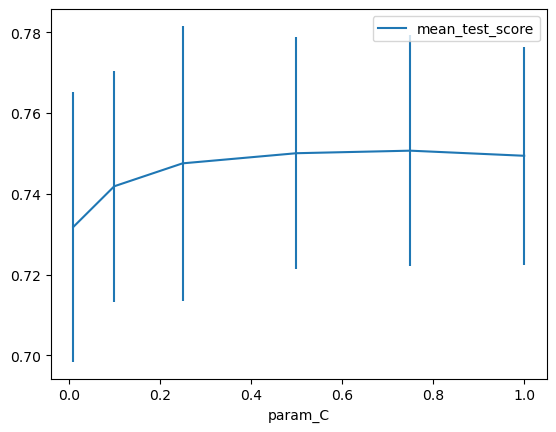

In [28]:
grid_results_svc_l1.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Logistic Regression (L2 regularization)

In [33]:
parameters = {"C":[0.01, 0.1, 0.5, 1, 2.5, 5, 10]}
lr_l2 = LogisticRegression(penalty="l2", max_iter=1000, dual=False, random_state=0)
grs_lr_l2 = GridSearchCV(lr_l2, parameters, cv=10, scoring="balanced_accuracy")
grs_lr_l2.fit(X_train_bal, y_train_bal)

grid_results_lr_l2 = pd.DataFrame(grs_lr_l2.cv_results_).sort_values("param_C")
grid_results_lr_l2.sort_values("rank_test_score")

# different solvers do not influence the accuracy, tested: "solver":["newton-cg", "lbfgs", "saga"]
# no significant difference for C between 1 and 5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.034574,0.004027,0.002157,0.000328,1,{'C': 1},0.72500,0.72500,0.767247,0.710839,0.792563,0.767326,0.779589,0.723180,0.742722,0.767563,0.750103,0.026738,1
5,0.056022,0.006073,0.002100,0.000301,5,{'C': 5},0.72500,0.71875,0.767326,0.710839,0.786234,0.761076,0.779589,0.729430,0.748972,0.773734,0.750095,0.025950,2
4,0.047126,0.005950,0.002169,0.000328,2.5,{'C': 2.5},0.72500,0.72500,0.773576,0.704509,0.786234,0.761076,0.779589,0.729430,0.748972,0.767484,0.750087,0.026298,3
2,0.029439,0.002484,0.002281,0.000612,0.5,{'C': 0.5},0.72500,0.72500,0.767247,0.717168,0.792563,0.767326,0.767089,0.723259,0.742722,0.767563,0.749494,0.024705,4
6,0.060090,0.004955,0.002260,0.000412,10,{'C': 10},0.72500,0.72500,0.767326,0.704509,0.786234,0.767405,0.773339,0.729430,0.748972,0.767484,0.749470,0.025509,5
1,0.016234,0.001523,0.001999,0.000001,0.1,{'C': 0.1},0.71250,0.70625,0.754905,0.717089,0.798734,0.760997,0.773418,0.723339,0.748892,0.742563,0.743869,0.028042,6
0,0.011454,0.001794,0.002403,0.000663,0.01,{'C': 0.01},0.73125,0.69375,0.710522,0.654193,0.804747,0.735759,0.754589,0.717009,0.742405,0.748734,0.729296,0.037862,7


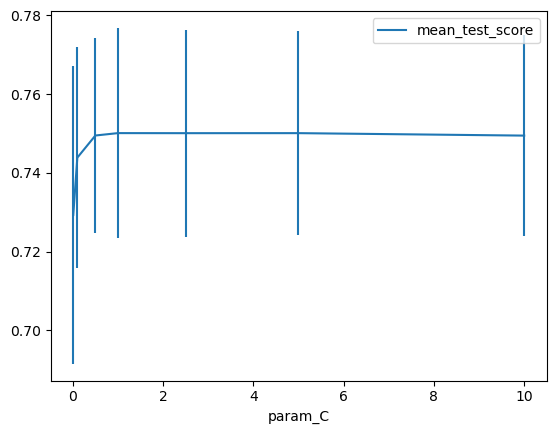

In [34]:
grid_results_lr_l2.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Logistic Regression (L1 regularization)

In [42]:
parameters = {"C":[0.1, 0.5, 1, 2.5, 5, 7.5, 10]}
lr_l1 = LogisticRegression(penalty="l1", solver="saga", max_iter=10000, dual=False, random_state=0)
grs_lr_l1 = GridSearchCV(lr_l1, parameters, cv=10, scoring="balanced_accuracy")
grs_lr_l1.fit(X_train_bal, y_train_bal)

grid_results_lr_l1 = pd.DataFrame(grs_lr_l1.cv_results_).sort_values("param_C")
grid_results_lr_l1.sort_values("rank_test_score")

# liblinear much faster than saga
# saga outperforms liblinear for high C values (>=5)
# liblinear outperforms saga for lower C values (0.1, 1)
# higher C values outperform lower C values (optimum at C=5 for both solvers)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,1.285805,0.236092,0.002400,0.000779,2.5,{'C': 2.5},0.72500,0.71875,0.773576,0.710839,0.792563,0.761076,0.785839,0.729430,0.742642,0.780063,0.751978,0.028726,1
4,3.454914,1.625466,0.002179,0.000555,5,{'C': 5},0.72500,0.71875,0.779905,0.704509,0.786234,0.761076,0.767089,0.729430,0.748972,0.773734,0.749470,0.026977,2
5,5.178103,1.349756,0.002350,0.000467,7.5,{'C': 7.5},0.72500,0.71875,0.773576,0.710839,0.786234,0.761076,0.767089,0.729430,0.748972,0.773734,0.749470,0.025305,2
6,6.052164,0.936756,0.002396,0.000667,10,{'C': 10},0.72500,0.71875,0.773576,0.704509,0.786234,0.761076,0.767089,0.729430,0.748972,0.773734,0.748837,0.026322,4
2,0.942934,0.152404,0.002112,0.000292,1,{'C': 1},0.71875,0.71875,0.773576,0.704589,0.792563,0.767326,0.773339,0.716851,0.736313,0.761313,0.746337,0.029168,5
1,0.498388,0.099959,0.001808,0.000591,0.5,{'C': 0.5},0.71875,0.71875,0.760997,0.704589,0.786234,0.779826,0.767168,0.710680,0.730063,0.761313,0.743837,0.028853,6
0,0.210127,0.073797,0.001910,0.000714,0.1,{'C': 0.1},0.71250,0.73750,0.754747,0.685522,0.779826,0.779747,0.773497,0.717009,0.723734,0.729984,0.739407,0.030209,7


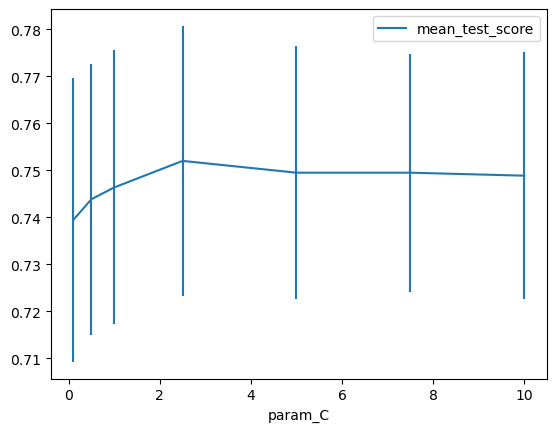

In [43]:
grid_results_lr_l1.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

## Final models & feature importance

### Random Forest

In [60]:
# train RF
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_rf = rf.predict(X_test_scal)
y_score_rf = rf.predict_proba(X_test_scal)

In [127]:
coef_rf = pd.Series(index=X_train_bal.columns, data=rf.feature_importances_, name="RF")
print("Number of features used:", len(coef_rf[coef_rf != 0]))
coef_rf.sort_values(ascending=False, key=abs)[:20]

Number of features used: 72


Signal peptide       0.037522
Helix_NSP            0.033573
Length               0.033044
Molecular weight     0.032555
Sheet_NSP            0.027299
ExpAA                0.025481
C                    0.025012
Hydrophobic          0.023432
Solubility           0.023381
L                    0.022737
H                    0.022424
D                    0.022085
Exposed              0.021684
Instability index    0.021431
Isoelectric point    0.021415
First60ExpAA         0.020803
Polarity_low         0.020416
Nucleus              0.019722
S                    0.018487
Turn_NSP             0.018484
Name: RF, dtype: float64

### Linear SVC

In [44]:
# train SVC , penalty = l2
svc_l2 = LinearSVC(C=0.25, max_iter=10000, dual=False, random_state=0)
svc_l2.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_svc_l2 = svc_l2.predict(X_test_scal)
y_score_svc_l2 = svc_l2.decision_function(X_test_scal)

In [132]:
coef_svc_l2 = pd.Series(index=X_train_bal.columns, data=svc_l2.coef_[0], name="SVC_L2")
print("Number of features used:", len(coef_svc_l2[coef_svc_l2 != 0]))
coef_svc_l2.sort_values(ascending=False, key=abs)[:20]

Number of features used: 72


Nucleus             -0.561470
Signal peptide       0.556741
PS00028             -0.479924
Golgi_apparatus      0.456672
Length               0.385062
Peroxisome          -0.321369
PS00022              0.313329
PS00027             -0.289866
PS00237             -0.289525
Molecular weight    -0.211520
GlycoMine_O          0.174986
GPI-anchor           0.162827
Lysosome/Vacuole     0.149288
ExpAA                0.127489
PS01186              0.124901
W                   -0.123570
Isoelectric point   -0.119172
Cytoplasm           -0.118898
GlycoMine_C         -0.113006
First60ExpAA         0.106682
Name: SVC_L2, dtype: float64

In [52]:
# train SVC , penalty = l1
svc_l1 = LinearSVC(penalty="l1", C=0.75, max_iter=10000, dual=False, random_state=0)
svc_l1.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_svc_l1 = svc_l1.predict(X_test_scal)
y_score_svc_l1 = svc_l1.decision_function(X_test_scal)

In [133]:
coef_svc_l1 = pd.Series(index=X_train_bal.columns, data=svc_l1.coef_[0], name="SVC_L1")
print("Number of features used:", len(coef_svc_l1[coef_svc_l1 != 0]))
coef_svc_l1[coef_svc_l1 != 0].sort_values(ascending=False, key=abs)[:20]

Number of features used: 49


Nucleus             -0.656926
Signal peptide       0.565076
PS00028             -0.509008
Peroxisome          -0.413281
Golgi_apparatus      0.369410
PS00022              0.354049
PS00027             -0.289872
PS00237             -0.287774
Cytoplasm           -0.210631
Hydrophobic         -0.197083
Length               0.185509
GlycoMine_O          0.174969
GPI-anchor           0.145419
Mitochondrion       -0.140747
S                   -0.127969
K                    0.125071
Polarity_low        -0.122393
W                   -0.115251
Isoelectric point   -0.113661
First60ExpAA         0.105163
Name: SVC_L1, dtype: float64

In [64]:
coef_svc_l1[coef_svc_l1 == 0]

A                        0.0
C                        0.0
M                        0.0
P                        0.0
R                        0.0
Y                        0.0
Polar                    0.0
Neutral                  0.0
Volume_small             0.0
Volume_medium            0.0
Volume_large             0.0
Polarity_medium          0.0
Polarity_large           0.0
Polarizability_large     0.0
Charge_neutral           0.0
Charge_negative          0.0
Buried                   0.0
Exposed                  0.0
Intermediate             0.0
Helix_NSP                0.0
Cell_membrane            0.0
Endoplasmic_reticulum    0.0
Plastid                  0.0
dtype: float64

### Logistic Regression

In [54]:
# train logistic classifier, penalty = l2
lr_l2 = LogisticRegression(penalty="l2", C=2.5, max_iter=1000, dual=False, random_state=0)
lr_l2.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_lr_l2 = lr_l2.predict(X_test_scal)
y_score_lr_l2 = lr_l2.decision_function(X_test_scal)

In [134]:
coef_lr_l2 = pd.Series(index=X_train_bal.columns, data=lr_l2.coef_[0], name="LR_L2")
print("Number of features used:", len(coef_lr_l2[coef_lr_l2 != 0]))
coef_lr_l2.sort_values(ascending=False, key=abs)[:20]

Number of features used: 72


Signal peptide       1.517978
PS00028             -1.463872
Nucleus             -1.411115
Golgi_apparatus      1.162611
PS00022              1.027397
Length               1.019526
PS00027             -0.997390
PS00237             -0.809654
Peroxisome          -0.741723
Molecular weight    -0.560149
PS01186              0.480944
GlycoMine_O          0.469675
GPI-anchor           0.457050
Lysosome/Vacuole     0.448605
GlycoMine_C         -0.422647
PS00232              0.382173
ExpAA                0.353146
Isoelectric point   -0.324803
W                   -0.321716
Cytoplasm           -0.288886
Name: LR_L2, dtype: float64

In [57]:
# train logistic classifier, penalty = l1
lr_l1 = LogisticRegression(penalty="l1", solver="saga", C=5, max_iter=10000, dual=False, random_state=0)
lr_l1.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_lr_l1 = lr_l1.predict(X_test_scal)
y_score_lr_l1 = lr_l1.decision_function(X_test_scal)

In [135]:
coef_lr_l1 = pd.Series(index=X_train_bal.columns, data=lr_l1.coef_[0], name="LR_L1")
print("Number of features used:", len(coef_lr_l1[coef_lr_l1 != 0]))
coef_lr_l1.sort_values(ascending=False, key=abs)[:20]

Number of features used: 49


Length               1.900578
PS00028             -1.789020
Nucleus             -1.642912
Signal peptide       1.544484
Molecular weight    -1.437794
PS00022              1.325786
PS00027             -1.103535
Peroxisome          -1.084314
Golgi_apparatus      0.957109
PS00237             -0.847330
Hydrophobic         -0.637070
Cytoplasm           -0.526673
GlycoMine_O          0.471406
GPI-anchor           0.446582
GlycoMine_C         -0.418737
S                   -0.348665
K                    0.338380
PS00232              0.330512
Isoelectric point   -0.322243
Polarity_low        -0.315457
Name: LR_L1, dtype: float64

In [65]:
coef_lr_l1[coef_lr_l1 == 0]

A                       0.0
C                       0.0
M                       0.0
P                       0.0
R                       0.0
Y                       0.0
Polar                   0.0
Neutral                 0.0
Volume_small            0.0
Volume_medium           0.0
Volume_large            0.0
Polarity_medium         0.0
Polarity_large          0.0
Polarizability_large    0.0
Charge_neutral          0.0
Charge_negative         0.0
Buried                  0.0
Exposed                 0.0
Intermediate            0.0
Helix_NSP               0.0
Cell_membrane           0.0
Plastid                 0.0
Glycosylation           0.0
dtype: float64

## Model evaluation

In [77]:
models = [rf, svc_l2, svc_l1, lr_l2, lr_l1]
model_names = ["Random Forest", "SVC (L2)", "SVC (L1)", "Logistic Classifier (L2)", "Logistic Classifier (L1)"]

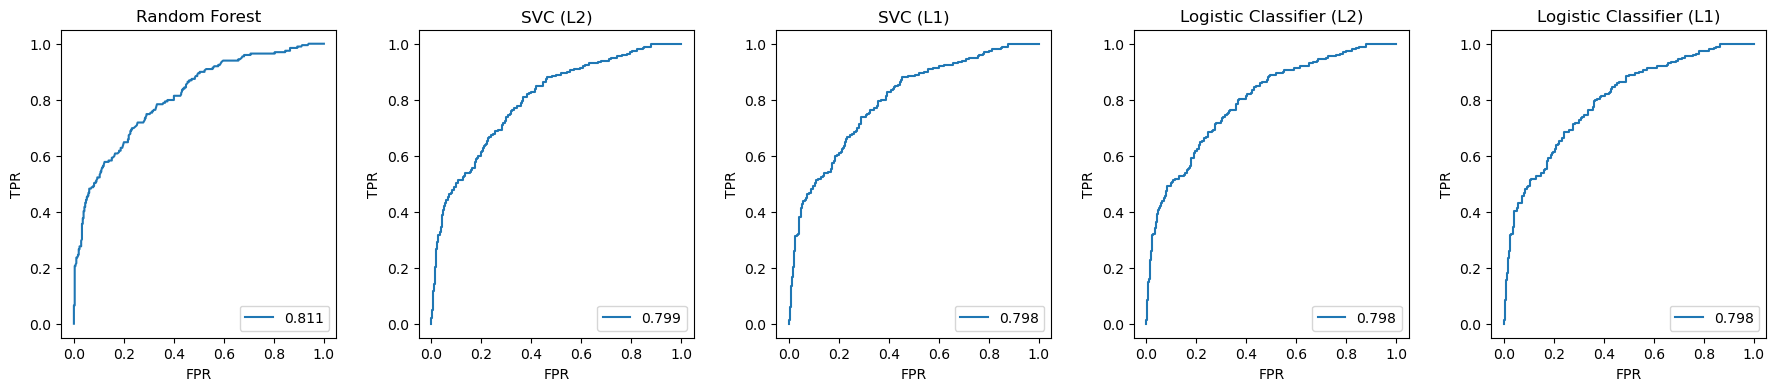

In [92]:
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
fig.subplots_adjust(wspace=0.3)

for i in range(5):
    RocCurveDisplay.from_estimator(models[i], X_test_scal, y_test, ax=ax[i])
    ax[i].set(xlabel="FPR", ylabel="TPR", title=model_names[i])
    try:
        ax[i].legend(labels=[round(roc_auc_score(y_test, models[i].predict_proba(X_test_scal)[:, 1]), 3)], loc="lower right")
    except:
        ax[i].legend(labels=[round(roc_auc_score(y_test, models[i].decision_function(X_test_scal)), 3)], loc="lower right")

plt.show()
fig.savefig(fig_path + "Final_models_AUC_ROC_curve.png", bbox_inches="tight")

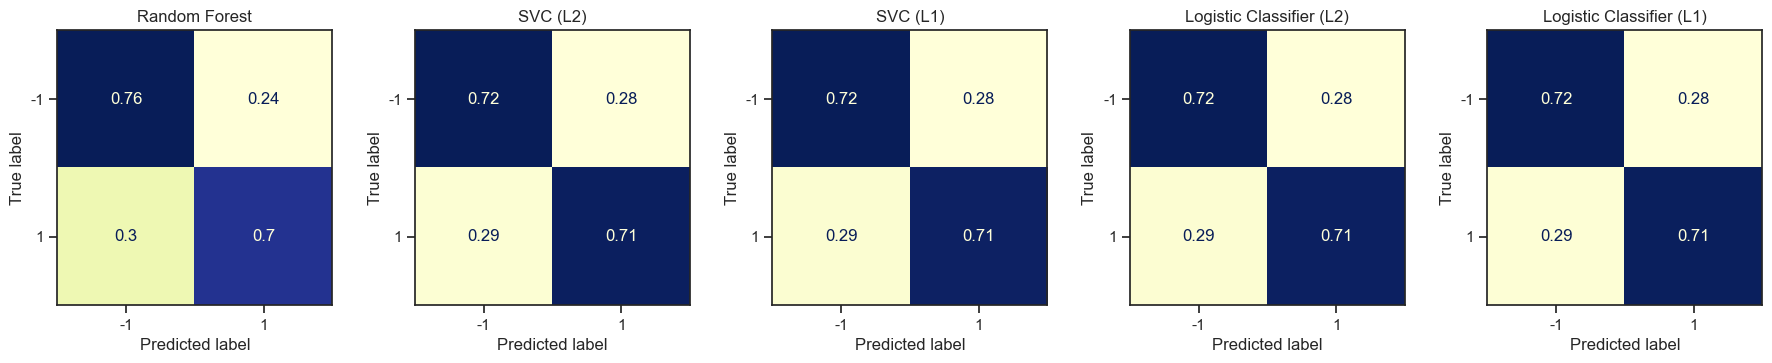

In [253]:
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
fig.subplots_adjust(wspace=0.3)

for i in range(5):
    ConfusionMatrixDisplay.from_estimator(models[i], X_test_scal, y_test, normalize="true", colorbar=False, cmap="YlGnBu", 
        ax=ax[i])
    ax[i].set(title=model_names[i])

plt.show()
fig.savefig(fig_path + "Final_models_confusion_matrix.png", bbox_inches="tight")

In [329]:
# save model
#### TO DO ####

## Feature importance

In [164]:
rank_rf = abs(coef_rf).rank().sort_values()
rank_svc_l2 = abs(coef_svc_l2).rank().sort_values()
rank_svc_l1 = abs(coef_svc_l1[coef_svc_l1 != 0]).rank().sort_values()
rank_lr_l2 = abs(coef_lr_l2).rank().sort_values()
rank_lr_l1 = abs(coef_lr_l1[coef_lr_l1 != 0]).rank().sort_values()

In [168]:
all_ranks = pd.merge(rank_rf, rank_svc_l2, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_svc_l1, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_lr_l2, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_lr_l1, left_index=True, right_index=True, how="outer")
all_ranks.fillna(0, inplace=True)
all_ranks["Mean"] = all_ranks.mean(axis=1)
all_ranks.sort_values("Mean", ascending=False, inplace=True)
all_ranks[:10]

,RF,SVC_L2,SVC_L1,LR_L2,LR_L1,Mean
Signal peptide,72.0,71.0,48.0,72.0,46.0,61.8
Nucleus,55.0,72.0,49.0,70.0,47.0,58.6
Length,70.0,68.0,39.0,67.0,49.0,58.6
Molecular weight,69.0,63.0,7.0,63.0,45.0,49.4
PS00028,6.0,70.0,47.0,71.0,48.0,48.4
Golgi_apparatus,14.0,69.0,45.0,69.0,41.0,47.6
ExpAA,67.0,59.0,24.0,56.0,29.0,47.0
Isoelectric point,58.0,56.0,31.0,55.0,31.0,46.2
PS00022,8.0,66.0,44.0,68.0,44.0,46.0
Hydrophobic,65.0,40.0,40.0,42.0,39.0,45.2


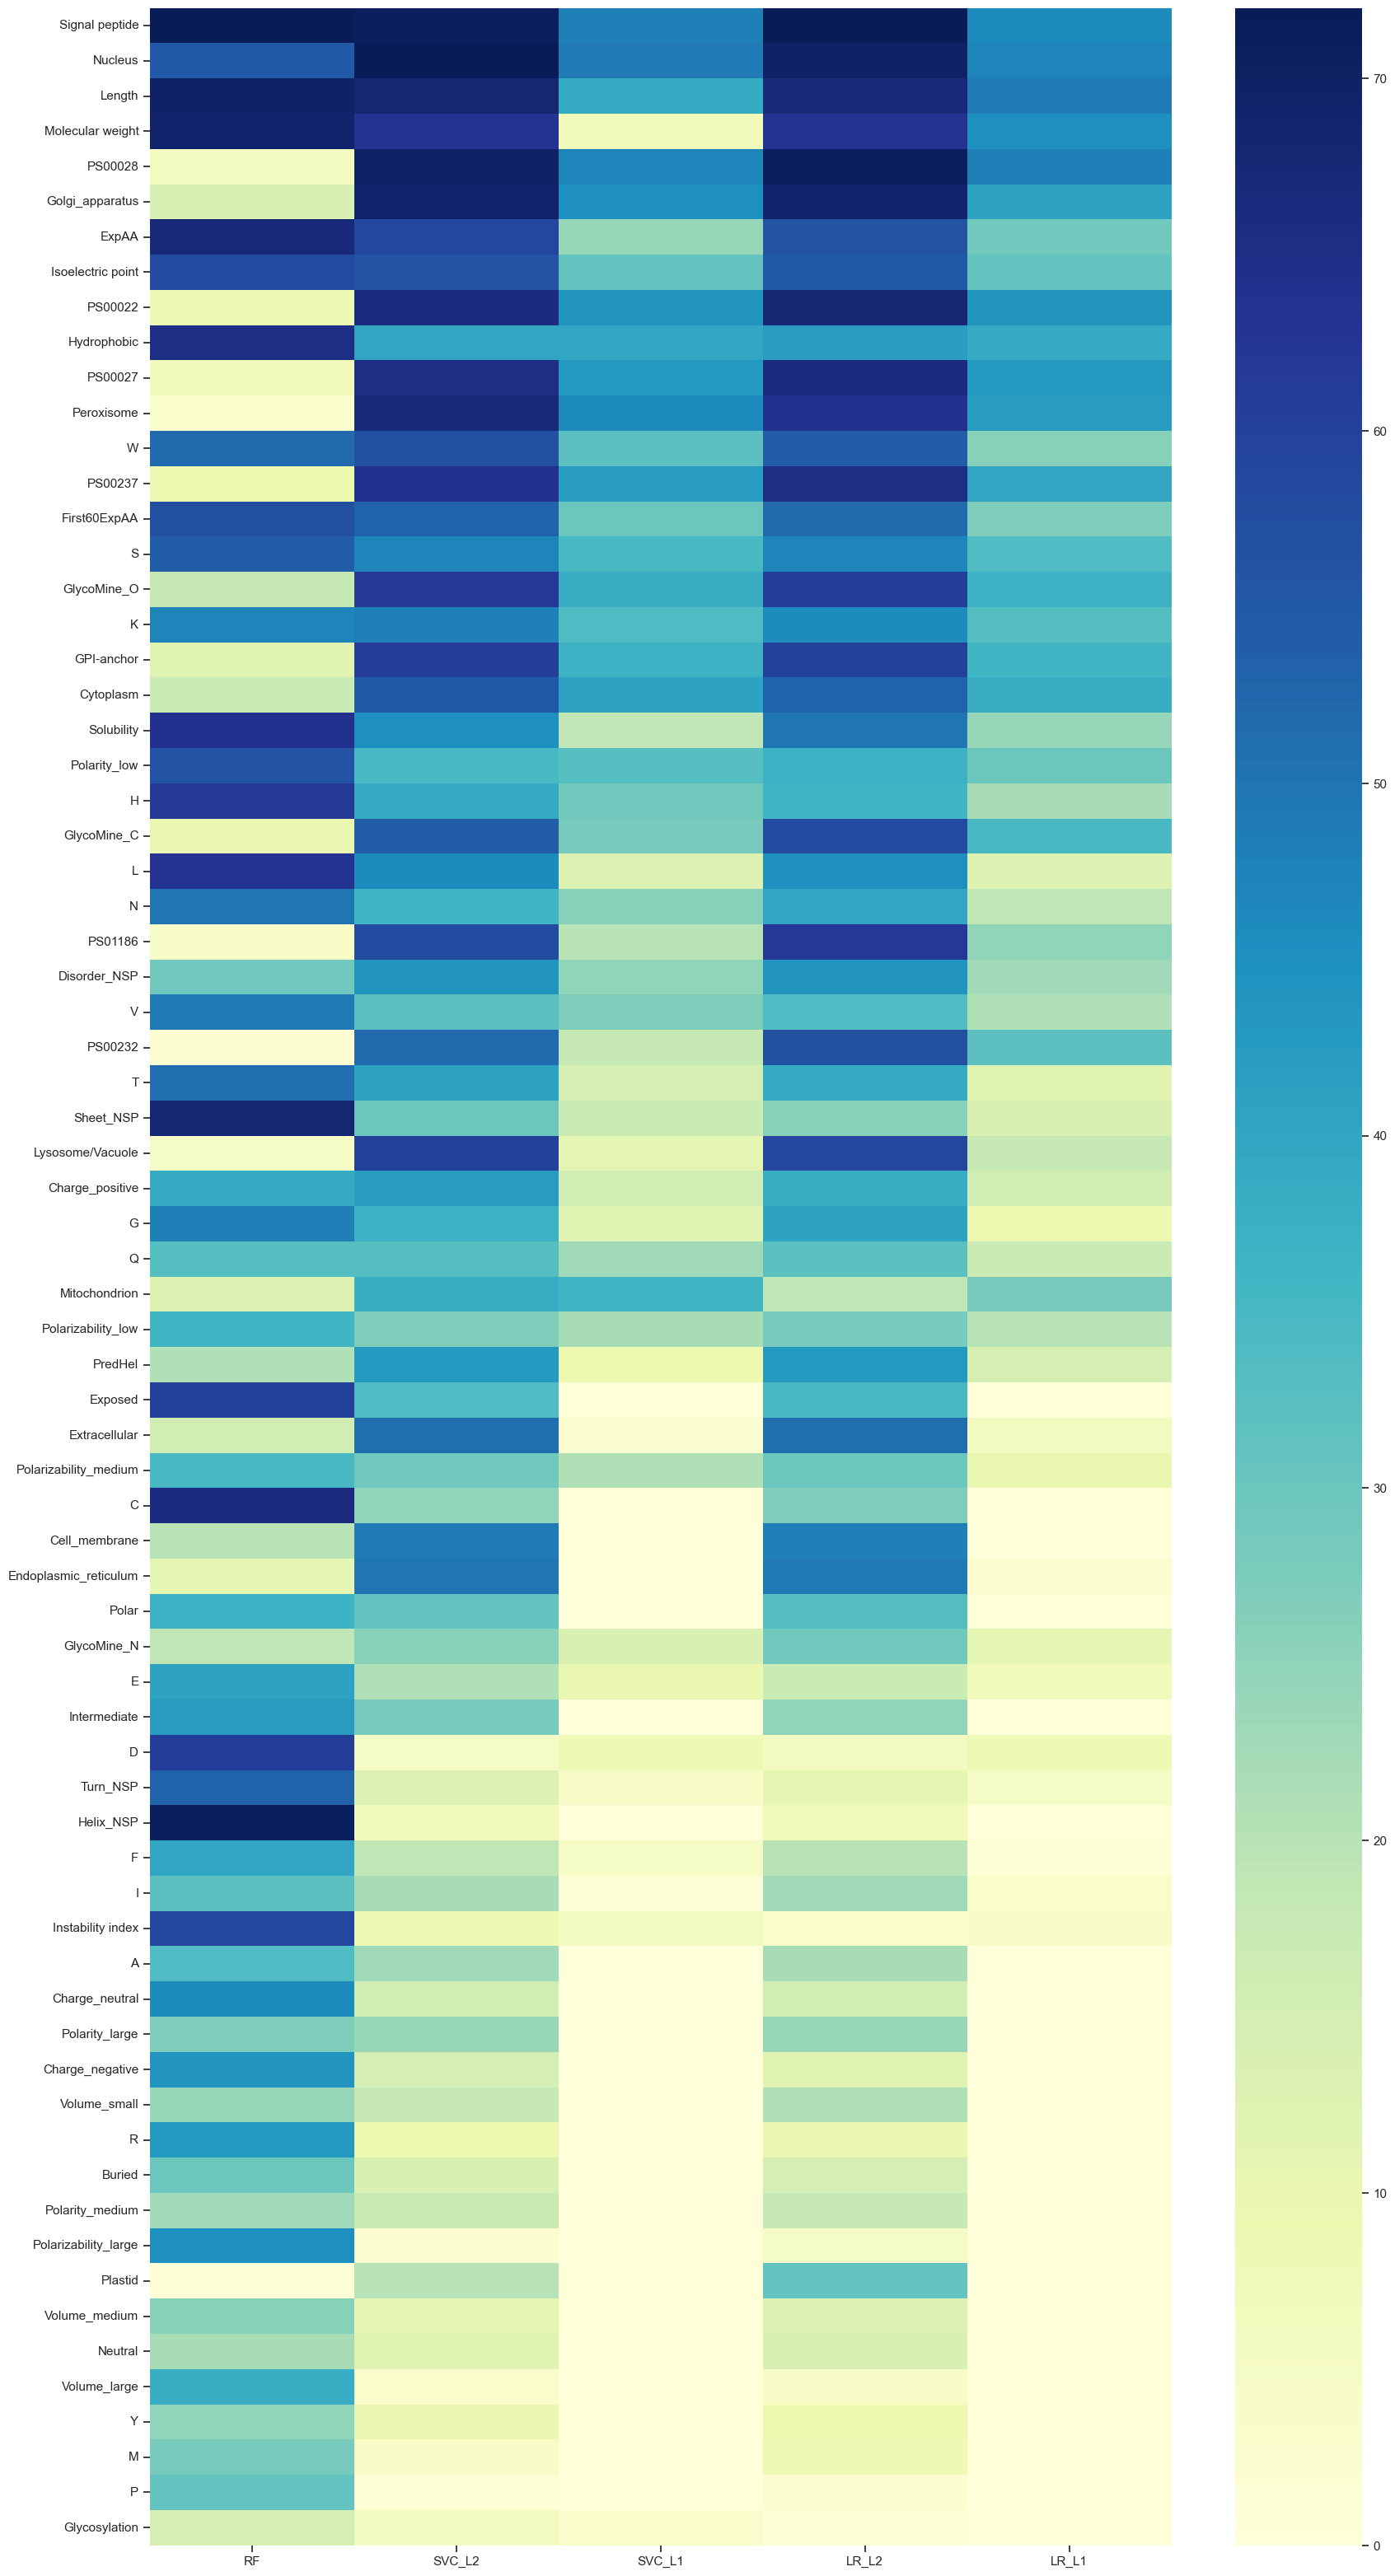

In [202]:
fig = plt.figure(figsize=(20, 40))

sns.heatmap(all_ranks[["RF", "SVC_L2", "SVC_L1", "LR_L2", "LR_L1"]], cmap="YlGnBu")
plt.show()
fig.savefig(fig_path + "Heatmap_feature_ranking.png", bbox_inches="tight")

## Dataset stringency

In [98]:
def increase_stringency_CSF(feature_df, csf_df, i):
    
    stringent_csf = csf_df[csf_df["#Studies"]>=i]["Uniprot"]
    remove_csf = set(df_features[df_features["CSF"] == 1]["Uniprot"]) - set(stringent_csf)
    df_stringent = df_features.drop(df_features[(df_features["CSF"] == 1) & (df_features["Uniprot"].isin(remove_csf))].index)
    
    print("Number of CSF proteins to be removed:", len(remove_csf))
    print("Number of CSF proteins left:", len(df_stringent[(df_stringent["CSF"] == 1)]))   
    
    return df_stringent


def increase_stringency_brain(feature_df, brain_set):

    df_stringent = feature_df[feature_df["Uniprot"].isin(brain_set)]
    print("Number of brain proteins to be removed:", len(df_features) - len(df_stringent))
    print("Number of CSF proteins left:", len(df_stringent[(df_stringent["CSF"] == 1)]))   
    print("Number of non-CSF proteins left:", len(df_stringent[(df_stringent["CSF"] == -1)])) 
    
    return df_stringent


def accuracy_stringent(df, n):
    
    # define explanatory and response variables
    X = (df.drop(["Uniprot", "Sequence", "CSF"], axis=1))
    y = (df["CSF"])
    
    bac = []
    auc = []
    
    for i in range(10):
        
        X_train_bal, X_test_scal, y_train_bal, y_test = preprocess(X, y, random_state=i)
        
        # train model
        lr = LogisticRegression(C=2.5, max_iter=1000, dual=False, random_state=0).fit(X_train_bal, y_train_bal)
        y_pred = lr.predict(X_test_scal)
        
        # print(i, "Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
        bac.append(balanced_accuracy_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, lr.decision_function(X_test_scal)))
        
        if i == 0:
            coef = pd.Series(index=X_train_bal.columns, data=lr.coef_[0], name=n)
            coef.sort_values(ascending=False, key=abs, inplace=True)

    return bac, auc, coef

### CSF proteins

In [96]:
csf["#Studies"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].count(axis=1)

In [99]:
baclist_csf = []
auclist_csf = []
coefs = []

print("Number of non-CSF proteins:", len(df_features[df_features["CSF"] == -1]))

for i in range(1, csf["#Studies"].max()+1):
    print("-------------")
    print("Number of minimum CSF studies:", i)
    df_stringent = increase_stringency_CSF(df_features, csf, i)
    bac, auc, coef = accuracy_stringent(df_stringent, n=i)
    
    baclist_csf.append(bac)
    auclist_csf.append(auc)
    coefs.append(coef)

Number of non-CSF proteins: 1547
-------------
Number of minimum CSF studies: 1
Number of CSF proteins to be removed: 0
Number of CSF proteins left: 995
-------------
Number of minimum CSF studies: 2
Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
-------------
Number of minimum CSF studies: 3
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541
-------------
Number of minimum CSF studies: 4
Number of CSF proteins to be removed: 521
Number of CSF proteins left: 474
-------------
Number of minimum CSF studies: 5
Number of CSF proteins to be removed: 588
Number of CSF proteins left: 407
-------------
Number of minimum CSF studies: 6
Number of CSF proteins to be removed: 693
Number of CSF proteins left: 302
-------------
Number of minimum CSF studies: 7
Number of CSF proteins to be removed: 833
Number of CSF proteins left: 162


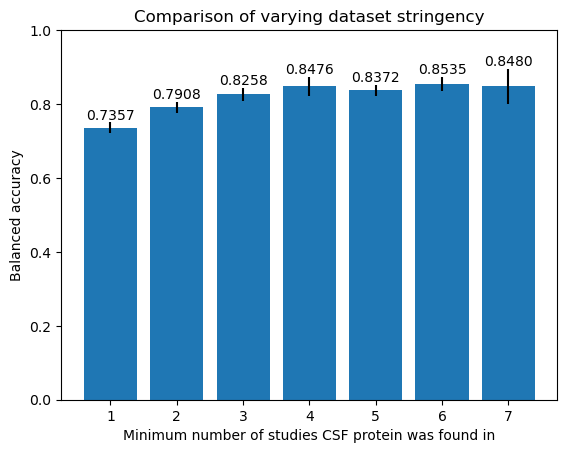

In [100]:
fig, ax = plt.subplots()

bars = ax.bar(x=[1,2,3,4,5,6,7], height=[np.mean(i) for i in baclist_csf], yerr=[np.std(i) for i in baclist_csf])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of studies CSF protein was found in", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_CSF_BAC.png", bbox_inches="tight")

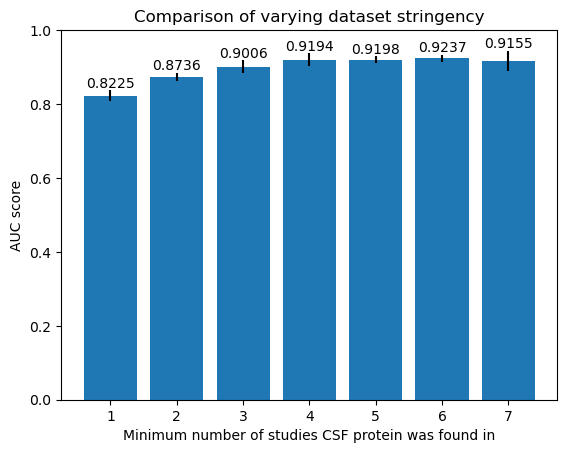

In [101]:
fig, ax = plt.subplots()

bars = ax.bar(x=[1,2,3,4,5,6,7], height=[np.mean(i) for i in auclist_csf], yerr=[np.std(i) for i in auclist_csf])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of studies CSF protein was found in", ylabel="AUC score", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_CSF_AUC.png", bbox_inches="tight")

## Influence of brain dataset stringency

In [128]:
baclist_brain = []
auclist_brain = []

brain_sets = [brain_tissue_enhanced, brain_group_enriched, brain_tissue_enriched]

print("Number of brain proteins:", len(df_features))

for i in range(len(brain_sets)):
    print("-------------")
    df_stringent = increase_stringency_brain(df_features, brain_sets[i])
    bac, auc, cm = accuracy_stringent(df_stringent, n=i)
    
    baclist_brain.append(bac)
    auclist_brain.append(auc)

Number of brain proteins: 2542
-------------
Number of brain proteins to be removed: 0
Number of CSF proteins left: 995
Number of non-CSF proteins left: 1547
-------------
Number of brain proteins to be removed: 1459
Number of CSF proteins left: 424
Number of non-CSF proteins left: 659
-------------
Number of brain proteins to be removed: 2056
Number of CSF proteins left: 201
Number of non-CSF proteins left: 285


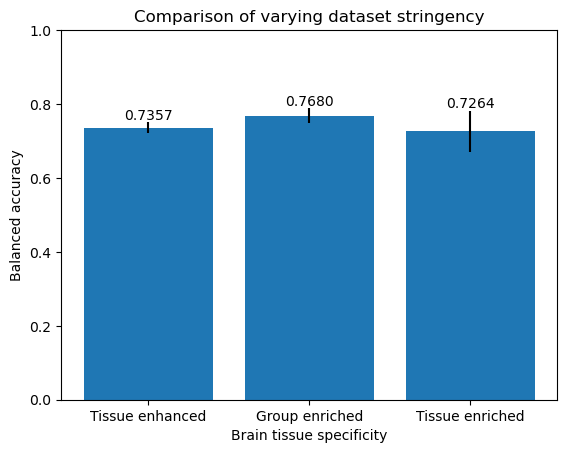

In [129]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Tissue enhanced", "Group enriched", "Tissue enriched"], height=[np.mean(i) for i in baclist_brain], yerr=[np.std(i) for i in baclist_brain])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Brain tissue specificity", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_brain_specifcity_BAC.png", bbox_inches="tight")

In [131]:
baclist_brain = []
auclist_brain = []

brain_sets = [brain_all, brain_many, brain_some, brain_single]

print("Number of brain proteins:", len(df_features))

for i in range(len(brain_sets)):
    print("-------------")
    df_stringent = increase_stringency_brain(df_features, brain_sets[i])
    bac, auc, cm = accuracy_stringent(df_stringent, n=i)
    
    baclist_brain.append(bac)
    auclist_brain.append(auc)

Number of brain proteins: 2542
-------------
Number of brain proteins to be removed: 0
Number of CSF proteins left: 995
Number of non-CSF proteins left: 1547
-------------
Number of brain proteins to be removed: 331
Number of CSF proteins left: 846
Number of non-CSF proteins left: 1365
-------------
Number of brain proteins to be removed: 1382
Number of CSF proteins left: 348
Number of non-CSF proteins left: 812
-------------
Number of brain proteins to be removed: 2377
Number of CSF proteins left: 35
Number of non-CSF proteins left: 130


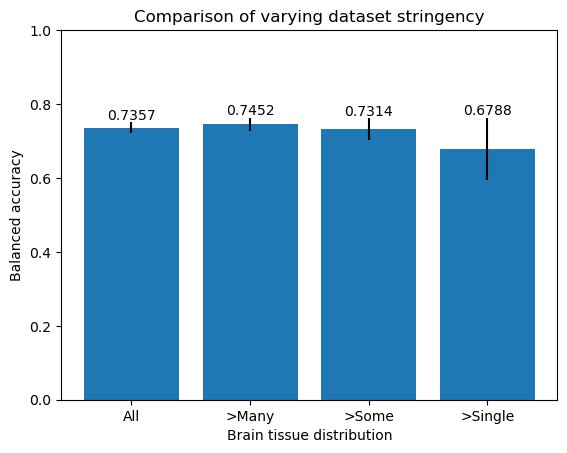

In [132]:
fig, ax = plt.subplots()

bars = ax.bar(x=["All", ">Many", ">Some", ">Single"], height=[np.mean(i) for i in baclist_brain], yerr=[np.std(i) for i in baclist_brain])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Brain tissue distribution", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_brain_distribution_BAC.png", bbox_inches="tight")

## Feature analysis of models trained on more stringent CSF data

In [158]:
def stringent_dataset_analysis(df):
    
    # define explanatory and response variables
    X = (df.drop(["Uniprot", "Sequence", "CSF"], axis=1))
    y = (df["CSF"])
    
    coefs = []
    
    for i in range(10):
        
        # preprocessing 
        X_train_bal, X_test_scal, y_train_bal, y_test = preprocess(X, y, random_state=i)  

        # train model
        lr = LogisticRegression(C=1, max_iter=1000, dual=False, random_state=0).fit(X_train_bal, y_train_bal)
#         rf = RandomForestClassifier(n_estimators=1000, random_state=0).fit(X_train_bal, y_train_bal)
        
        # extract coefficients
        coef = pd.Series(index=X_train_bal.columns, data=lr.coef_[0], name=i)
#         coef = pd.Series(index=X_train_bal.columns, data=rf.feature_importances_, name=i)
        coef.sort_values(ascending=False, key=abs, inplace=True)
        coefs.append(coef)
    
    # merge all coefficient series into oen dataframe
    coefs_df = pd.merge(coefs[0], coefs[1], left_index=True, right_index=True)
    for i in range(2, len(coefs)):
        coefs_df = pd.merge(coefs_df, coefs[i], left_index=True, right_index=True)  
                        
    coefs_df["Mean"] = coefs_df.mean(axis=1)
    coefs_df["Standard deviation"] = coefs_df.std(axis=1)
                        
    return coefs_df

In [166]:
# create more stirngent data sets
df_features_2plus = increase_stringency_CSF(df_features, csf, 2)
print("Number of proteins in dataset:", len(df_features_2plus))
print("-------------")
df_features_3plus = increase_stringency_CSF(df_features, csf, 3)
print("Number of proteins in dataset:", len(df_features_3plus))

Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
Number of proteins in dataset: 2239
-------------
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541
Number of proteins in dataset: 2088


In [167]:
coefs_df = stringent_dataset_analysis(df_features)
coefs_df_2plus = stringent_dataset_analysis(df_features_2plus)
coefs_df_3plus = stringent_dataset_analysis(df_features_3plus)

In [168]:
coefs_df.sort_values("Mean", ascending=False, key=abs)[:20]

,0,1,2,3,4,5,6,7,8,9,Mean,Standard deviation
Nucleus,-1.401095,-1.529225,-1.675793,-1.569935,-1.622848,-1.467908,-1.576934,-1.508069,-1.715290,-1.477657,-1.554475,0.092579
Signal peptide,1.483132,1.697421,1.261622,1.192728,1.473698,1.246399,1.403415,1.403540,1.377920,1.352353,1.389223,0.137159
Golgi_apparatus,1.074567,1.256806,1.135714,1.254022,1.714156,1.538856,1.446474,1.043691,1.121858,1.162946,1.274909,0.210176
PS00028,-1.097539,-1.150599,-1.185515,-1.195571,-1.087406,-1.525500,-1.039353,-1.381101,-1.130479,-1.252839,-1.204590,0.140647
PS00027,-0.791480,-0.875238,-0.827775,-0.502248,-0.925326,-0.934436,-0.847378,-0.943003,-0.936610,-1.096858,-0.868035,0.145648
PS00022,0.810861,0.802958,0.420138,0.608675,0.691775,0.762413,0.727125,0.771255,0.927158,0.748950,0.727131,0.128828
PS00237,-0.730962,-0.537729,-0.621350,-0.710300,-0.819818,-0.864529,-0.538986,-1.191816,-0.608073,-0.484919,-0.710848,0.199085
PS01186,0.446630,0.537190,0.638435,0.745528,0.691323,1.094137,0.585846,0.533574,0.654446,0.212168,0.613928,0.214169
Length,0.573498,0.544559,0.590621,0.402801,0.479736,0.812026,0.793466,0.484936,0.518767,0.661948,0.586236,0.127036
Peroxisome,-0.517031,-0.590948,-0.009468,-0.186508,-0.273426,-0.638466,-1.028468,-0.558814,-0.753843,-0.725638,-0.528261,0.284265


In [169]:
coefs_df_2plus.sort_values("Mean", ascending=False, key=abs)[:20]

,0,1,2,3,4,5,6,7,8,9,Mean,Standard deviation
Nucleus,-2.190559,-1.815185,-1.662165,-1.806479,-1.756693,-2.222634,-1.908491,-1.942562,-1.516757,-1.973243,-1.879477,0.207719
Golgi_apparatus,1.830254,2.350592,1.500562,1.463792,1.363220,2.142933,1.728493,1.672786,1.568015,1.519174,1.713982,0.299188
Signal peptide,1.567826,1.503611,1.767588,1.652790,1.977206,1.594300,1.642535,1.823930,1.871007,1.213752,1.661454,0.205021
Extracellular,0.964888,0.699593,0.634598,1.068834,0.725887,0.685124,0.719579,0.769283,0.735202,1.304799,0.830779,0.203112
PS00028,-0.850917,-0.389798,-0.994621,-0.647176,-0.579846,-0.978271,-0.863614,-0.980350,-1.046699,-0.754009,-0.808530,0.202771
Endoplasmic_reticulum,0.540466,0.840030,0.962694,1.384677,0.214560,0.891300,0.649241,0.874557,0.783697,0.658730,0.779995,0.288593
PS00022,0.644687,0.613714,1.045507,0.758631,0.573818,1.059798,1.183157,0.600360,0.976727,0.318768,0.777517,0.261513
Peroxisome,-0.911727,-0.877373,-0.342947,-0.787018,-0.575701,-0.775118,-0.450452,-1.083446,-0.543762,-0.979115,-0.732666,0.230953
PS00237,-0.581377,-0.526679,-0.933879,-1.309212,-0.904501,-0.074032,-0.691446,-0.405737,-0.375068,-1.152008,-0.695394,0.360548
Lysosome/Vacuole,-0.954751,-0.732506,-0.827458,-1.345648,-0.271060,-0.499543,-0.387475,-0.329920,-1.062313,-0.433177,-0.684385,0.340278


In [170]:
coefs_df_3plus.sort_values("Mean", ascending=False, key=abs)[:20]

,0,1,2,3,4,5,6,7,8,9,Mean,Standard deviation
Nucleus,-1.840154,-2.341021,-1.946673,-2.157195,-2.392903,-2.855930,-2.299998,-2.307020,-2.545442,-2.397121,-2.308346,0.272963
Golgi_apparatus,1.827573,2.085495,2.007416,2.175437,2.113702,1.628932,1.586092,1.641020,2.043101,1.710160,1.881893,0.215651
Signal peptide,2.033927,1.863179,1.682081,1.700298,1.741777,1.591909,1.669548,1.791864,1.915384,1.787751,1.777772,0.124442
Extracellular,0.809621,1.213374,1.139216,1.226410,0.593803,1.267928,1.011498,0.684217,0.873884,1.447643,1.026759,0.264230
GPI-anchor,0.746607,0.794493,1.545285,1.060511,1.154944,0.750250,0.862089,0.313600,1.092569,-0.495798,0.782455,0.525044
Endoplasmic_reticulum,0.445100,0.291717,1.038381,1.132704,0.467528,0.920281,0.514064,0.835960,0.731445,0.793053,0.717023,0.263776
PS00022,0.679279,1.029207,0.747903,0.627132,1.082991,0.826224,0.553749,0.975057,0.361684,0.237199,0.712043,0.265191
Peroxisome,-1.023972,-0.826131,-0.294208,-0.740144,-0.681131,-0.636193,-0.689905,-0.507360,-0.622890,-0.696020,-0.671795,0.180774
ExpAA,0.539152,0.319018,0.668248,1.006950,0.748884,0.863672,0.732025,0.572039,0.409303,0.762443,0.662173,0.196702
PS00027,-0.468315,-0.545597,-0.518424,-0.517836,-0.797039,-0.766195,-0.531518,-0.662791,-0.799521,-0.667066,-0.627430,0.120651
